# OpSim -- the updated simulation notebook

## About

This notebook is for testing of the OpSim functionality.
Data is read from prefabricated files containing the Sun and the two Satellites' positions as time series. The data is stored and read in the HDF5 format.

In [5]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility ---
import  os, sys

import  numpy as np
import  yaml
import  matplotlib.pyplot as plt
import  simpy

# ---------------------------------------------------------
import  lusee        # Core lusee software
import  nav          # Astro/observation wrapper classes
from    nav import *
from    utils.timeconv import *

import  sim          # Main simulation handler
from    sim import Simulator

print("---------------------------------- PATH ----------------------------------------")
for path_part in sys.path:
    if path_part!='': print(f'''{path_part}''')



print('--------------------------------- VERSIONS -------------------------------------')
print(f'''simpy: {simpy.__version__}, lusee: {lusee.__version__}, sim: {sim.__version__}''')

# Define paths in one place:
orbitals    = "../data/20250204-20250807.hdf5"
modes       = "../config/modes.yml"
devices     = "../config/devices.yml"

# comtable    = "../config/comtable-20250204-20250807-new.yml"
comtable    = "./simulator_log.yml"

initial_time=1548
until=11465

smltr = Simulator(orbitals, modes, devices, comtable, initial_time=initial_time, until=until)

mjd_start   = smltr.sun.mjd[initial_time]
mjd_end     = smltr.sun.mjd[until]

print(f'''Initial time in ticks: {initial_time}, mjd: {mjd_start}, datetime: {mjd2dt(mjd_start)}''')
print(f'''Until time in ticks: {until}, mjd: {mjd_end}, datetime: {mjd2dt(mjd_end)}''')

print(smltr.schedule)

# OPTIONAL
# smltr.info()

---------------------------------- PATH ----------------------------------------
/home/maxim/projects/lusee/opsim/notebooks
/home/maxim/projects/lusee/luseepy
/home/maxim/projects/lusee/opsim
/home/maxim/.virtualenvs/lusee/lib/python3.10/site-packages/backports
/usr/local/lib/python310.zip
/usr/local/lib/python3.10
/usr/local/lib/python3.10/lib-dynload
/home/maxim/.virtualenvs/lusee-simpy/lib/python3.10/site-packages
--------------------------------- VERSIONS -------------------------------------
simpy: 4.0.2, lusee: 1.2-dev, sim: 0.1
Shape of the data payload: (17760, 7)
Created a Battery with initial charge: 100.0, capacity: 1200.0
Initial time in ticks: 1548, mjd: 60726.125, datetime: 2025-02-20 03:00:00
Until time in ticks: 11465, mjd: 60829.427083333336, datetime: 2025-06-03 10:15:00
{60726.125: 1, 60740.0: 2, 60756.0: 3, 60770.0: 4, 60785.0: 5, 60800.0: 6}


---

### Run the simulation

In [6]:
# Set verbose if needed:
smltr.verbose = True
smltr.simulate()
smltr.save_record()

Clock:60726.125, mode: charge
Device states: {'spectrometer': 'OFF', 'comms': 'OFF', 'bms': 'ON', 'controller': 'ON'}
Device:spectrometer,   	state:OFF,	current:0.0
Device:comms,          	state:OFF,	current:0.0
Device:bms,            	state:ON,	current:0.1
Device:controller,     	state:ON,	current:0.3
*** Total current: 0.4
Clock:60740.0, mode: powersave
Device states: {'spectrometer': 'OFF', 'comms': 'OFF', 'bms': 'OFF', 'controller': 'ON'}
Device:spectrometer,   	state:OFF,	current:0.0
Device:comms,          	state:OFF,	current:0.0
Device:bms,            	state:OFF,	current:0.0
Device:controller,     	state:ON,	current:0.3
*** Total current: 0.3
Clock:60756.0, mode: charge
Device states: {'spectrometer': 'OFF', 'comms': 'OFF', 'bms': 'ON', 'controller': 'ON'}
Device:spectrometer,   	state:OFF,	current:0.0
Device:comms,          	state:OFF,	current:0.0
Device:bms,            	state:ON,	current:0.1
Device:controller,     	state:ON,	current:0.3
*** Total current: 0.4
Clock:60770.0, mod

---

### Plot the results

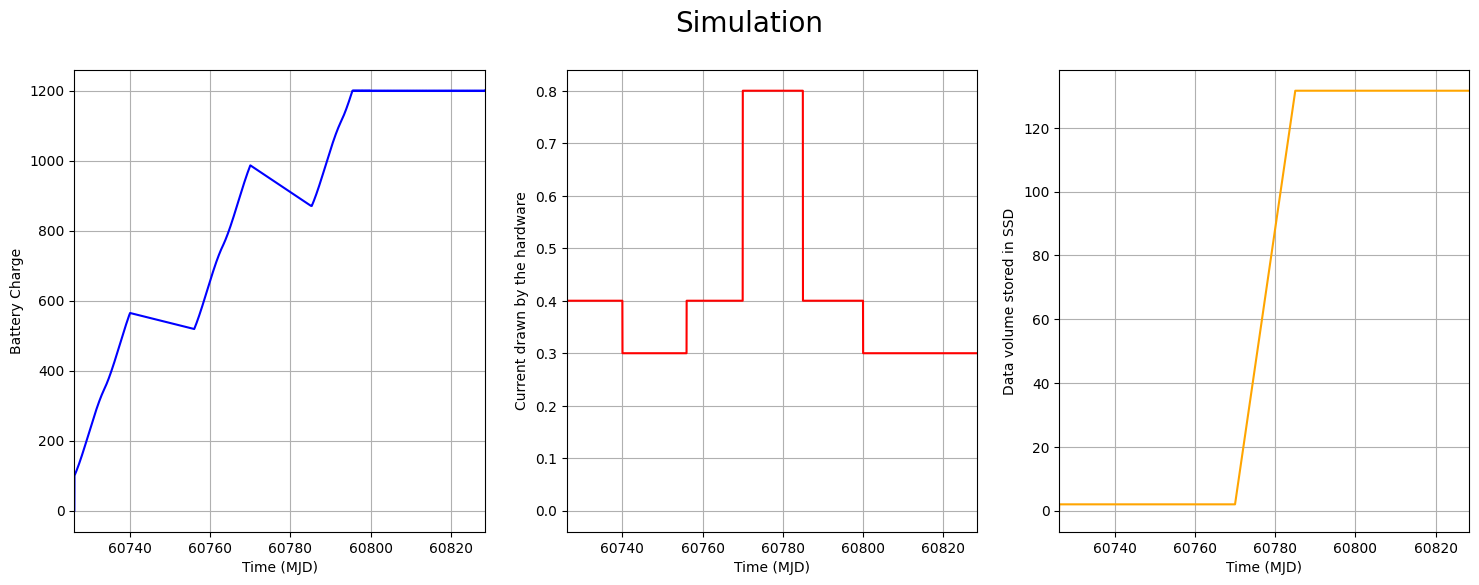

In [7]:
fig, (p1, p2, p3) = plt.subplots(1,3)
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [18., 6.]
# plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p1.set_ylabel('Battery Charge')

p2.set_xlabel('Time (MJD)')
p2.set_ylabel('Current drawn by the hardware')

p3.set_xlabel('Time (MJD)')
p3.set_ylabel('Data volume stored in SSD')

mjd = smltr.sun.mjd
p1.plot(mjd, smltr.monitor.battery, color="blue",   label="Battery")
p2.plot(mjd, smltr.monitor.current, color="red",    label="Current drawn (a.u.)")
p3.plot(mjd, smltr.monitor.ssd,     color="orange", label="SSD")

xlo = mjd[smltr.initial_time]
xhi = mjd[smltr.until] - 1

p1.set_xlim([xlo, xhi])
p2.set_xlim([xlo, xhi])
p3.set_xlim([xlo, xhi])

p1.grid(True)
p2.grid(True)
p3.grid(True)

plt.show()





In [ ]:
# Keep a cell for debugging:
# for c in smltr.monitor.current:
#    print(c)

---

### Optional -- some graphs.



In [ ]:
# OPTIONAL PLOTS

plt.rcParams["figure.figsize"] = [15., 5.]

# Get a handle on the sun and the satellite, in case needed for diagnostics
mySun = smltr.sun
myLpf = smltr.lpf
myBge = smltr.bge

print(mySun.N)

fig, (p1, p2, p3) = plt.subplots(1,3)

fig.suptitle('The Sun and the Sats', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p2.set_xlabel('Time (MJD)')

p1.plot(myLpf.mjd, myLpf.alt,  color="orange", label="Lpf Alt")
p1.plot(mySun.mjd, mySun.alt,  color="blue",   label="Sun Alt")

p2.plot(myLpf.mjd, myLpf.az, color="magenta",label="Lpf Az")
p2.plot(mySun.mjd, mySun.az, color="red",    label="Sun Az")


p3.plot(myLpf.mjd, myLpf.alt,  color="blue", label="Lpf Alt")
p3.plot(myBge.mjd, myBge.alt,  color="orange", label="Bge Alt")

p1.grid(True)
_ = p1.legend()

p2.grid(True)
_ = p2.legend()

p3.grid(True)
_ = p3.legend()

In [ ]:
# OPTIONAL

print(f'''Sunrise: {mySun.sunrise}''')

plt.rcParams["figure.figsize"] = [10., 10.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, smltr.controller.power*100.,  color="red",    label="Panel power*100")
ax.grid(True)
